In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

In [12]:
df = pd.read_csv('../Base_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)

df

,Q_entrada,NH_entrada,TSS_entrada,DQO_entrada,DBO_entrada,TN_entrada,TKN_entrada,TP_entrada,PO_entrada,Q_saida,NH_saida,NO_saida,TSS_saida,DQO_saida,DBO_saida,TN_saida,TKN_saida,TP_saida,PO_saida
Dia,,,,,,,,,,,,,,,,,,,
0.000000,4719.000000,21.000000,271.000000,391.000000,198.575000,34.060000,34.060000,8.020000,4.6,6135.066621,3.854908,0.079306,6.642565,83.782370,3.890641,5.042310,4.963005,0.428499,0.326124
0.041667,4766.833372,21.041667,271.208333,391.375000,198.761875,34.114167,34.114167,8.023333,4.6,4536.546366,3.110403,0.235010,6.475226,81.485161,3.157472,4.427449,4.192439,0.671496,0.573663
0.083333,4814.666743,21.083333,271.416667,391.750001,198.948750,34.168333,34.168333,8.026667,4.6,4584.379743,2.429280,0.285368,6.328465,80.156342,3.032321,3.777312,3.491944,1.125122,1.029731
0.125000,4862.500115,21.125000,271.625000,392.125001,199.135625,34.222500,34.222500,8.030000,4.6,4632.213115,1.858492,0.298568,6.245022,78.986079,2.977202,3.204324,2.905757,1.626430,1.532398
0.166667,4910.333486,21.166667,271.833334,392.500001,199.322501,34.276667,34.276667,8.033333,4.6,4680.046486,1.417633,0.298687,6.193657,77.894845,2.946727,2.750241,2.451555,2.150652,2.057467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364.833625,2891.467657,17.166375,173.332750,246.831874,126.034431,25.411331,25.411331,6.756655,4.6,2662.209157,0.117794,18.804470,3.245100,33.145931,1.527409,19.358707,0.554237,5.624398,5.579316
364.875292,2767.884225,17.124708,173.249416,246.623540,125.953181,25.363414,25.363414,6.754988,4.6,2538.625725,0.114032,18.859135,3.270412,33.142325,1.527662,19.410103,0.550968,5.688779,5.643467
364.916959,2644.300792,17.083041,173.166083,246.415207,125.871931,25.315498,25.315498,6.753322,4.6,2415.042292,0.110285,18.915739,3.302093,33.144707,1.529204,19.463677,0.547938,5.754875,5.709267


In [13]:
y = df['DQO_saida']
X = df.drop(['DQO_saida',
            'Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'], axis=1)

print("X", X.shape)
print("y", y.shape)

X (8761, 4)
y (8761,)


In [14]:
seed = 42

# separando treino e teste
X_training, X_test, y_training, y_test = train_test_split(X, y, shuffle=False, test_size=0.082) 
print("Test set X", X_test.shape)
print("Test set y", y_test.shape)

Test set X (719, 4)
Test set y (719,)


In [15]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_train = np.array(y_training).reshape(len(y_training),1)
y_testing = np.array(y_test).reshape(len(y_test),1)

scalery = StandardScaler().fit(y_train)
normalized_y_train = pd.DataFrame(
    scalery.transform(y_train),
    columns = [y_training.name],
    index = y_training.index
)
normalized_y_train = normalized_y_train.squeeze()

normalized_y_test = pd.DataFrame(
    scalery.transform(y_testing),
    columns = [y_test.name],
    index = y_test.index
)
normalized_y_test = normalized_y_test.squeeze()


# Padronização dos previsores (DataFrame X)
scalerX = StandardScaler().fit(X_training)

normalized_x_train = pd.DataFrame(
    scalerX.transform(X_training),
    columns = X_training.columns,
    index = X_training.index
)


normalized_x_test = pd.DataFrame(
    scalerX.transform(X_test),
    columns = X_test.columns,
    index = X_test.index
)

## Reshaping is important for LSTM

In [16]:
# reshape input to be 3D [samples, timesteps, features]
train_X = normalized_x_train.values.reshape((normalized_x_train.values.shape[0], 1, normalized_x_train.values.shape[1]))
test_X = normalized_x_test.values.reshape((normalized_x_test.values.shape[0], 1, normalized_x_test.values.shape[1]))
print(train_X.shape, normalized_y_train.shape, test_X.shape, normalized_y_test.shape)

(8042, 1, 4) (8042,) (719, 1, 4) (719,)


In [7]:
# design LSTM network with Dropout and L2 regularization
def create_model(neurons1, neurons2=0, dropout_rate=0.0, activation='relu', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(neurons1, input_shape=(train_X.shape[1], train_X.shape[2]), activation=activation,
                   kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation=activation)) #, activation='relu'
    model.add(Dropout(dropout_rate))
    # model.add(Dense(neurons2))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear')) #, kernel_initializer='uniform', activation='linear'
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    # fit network
    history = model.fit(train_X, normalized_y_train, epochs=100, batch_size=10, validation_data=(test_X, normalized_y_test), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model

model = KerasRegressor(model=create_model, neurons1=16, neurons2=0, dropout_rate=0.0, activation='relu', learning_rate=0.001, epochs=100,
                        batch_size=10, verbose=100) #build_fn=

# define the grid search parameters
neurons = [16, 32, 64, 128] 
# weight_constraint = [1.0, 5.0] #, 2.0, 3.0, 4.0
dropout_rate = [0.0, 0.1, 0.2] #, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
# activation = ["relu", "tanh"] #, 'softmax', 'softplus', 'softsign', 'sigmoid', 'hard_sigmoid', 'linear'
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']  # tem demais
learn_rate = [0.001, 0.01, 0.1] #,0.2, 0.3
param_grid = dict(neurons1=128, neurons2=32, dropout_rate=0.1, 
                  activation = ["relu"], learning_rate=0.01) #activation=activation
            
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/75


c:\Users\hydro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


805/805 - 2s - loss: 0.7843 - accuracy: 0.0000e+00 - val_loss: 0.1841 - val_accuracy: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/75
805/805 - 1s - loss: 0.6065 - accuracy: 0.0000e+00 - val_loss: 0.5932 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 3/75
805/805 - 1s - loss: 0.5819 - accuracy: 0.0000e+00 - val_loss: 0.5918 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 4/75
805/805 - 1s - loss: 0.5761 - accuracy: 0.0000e+00 - val_loss: 0.7343 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 5/75
805/805 - 1s - loss: 0.5906 - accuracy: 0.0000e+00 - val_loss: 0.4928 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 6/75
805/805 - 1s - loss: 0.5452 - accuracy: 0.0000e+00 - val_loss: 0.2376 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 7/75
805/805 - 1s - loss: 0.5859 - accuracy: 0.0000e+00 - val_loss: 0.5333 - val_accuracy: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 8/75
805/805 - 1s - loss: 0.5643 - accuracy: 0.0000e+00 - val_loss: 0.3459 - val_accuracy: 0.00

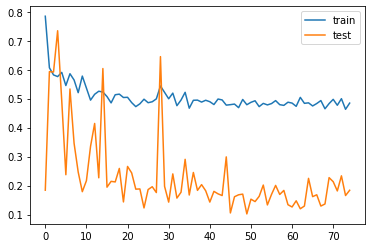

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [8]:
grid_result = grid_search.fit(train_X, normalized_y_train)

In [9]:
cv_results = pd.DataFrame(grid_result.cv_results_)
# summarize results
cv_best_params = grid_search.best_params_
print('\n Best hyperparameters:')
print(cv_best_params)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


 Best hyperparameters:
{'activation': 'relu', 'dropout_rate': 0.1, 'learning_rate': 0.01, 'neurons1': 128, 'neurons2': 32}
0.596056 (0.126876) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 16, 'neurons2': 16}
0.616883 (0.145102) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 16, 'neurons2': 32}
0.548230 (0.119131) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 16, 'neurons2': 64}
0.556669 (0.138268) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 16, 'neurons2': 128}
0.611128 (0.145381) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 32, 'neurons2': 16}
0.556462 (0.141746) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 32, 'neurons2': 32}
0.595302 (0.115987) with: {'activation': 'relu', 'dropout_rate': 0.0, 'learning_rate': 0.001, 'neurons1': 32, 'neurons2

Epoch 1/75
805/805 - 2s - loss: 0.7014 - accuracy: 0.0000e+00 - val_loss: 0.2404 - val_accuracy: 0.0000e+00 - 2s/epoch - 3ms/step
Epoch 2/75
805/805 - 1s - loss: 0.5793 - accuracy: 0.0000e+00 - val_loss: 0.6595 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 3/75
805/805 - 1s - loss: 0.5535 - accuracy: 0.0000e+00 - val_loss: 0.5152 - val_accuracy: 0.0000e+00 - 1s/epoch - 2ms/step
Epoch 4/75
805/805 - 1s - loss: 0.5392 - accuracy: 0.0000e+00 - val_loss: 0.4525 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 5/75
805/805 - 1s - loss: 0.5456 - accuracy: 0.0000e+00 - val_loss: 0.6109 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 6/75
805/805 - 1s - loss: 0.5440 - accuracy: 0.0000e+00 - val_loss: 0.4618 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 7/75
805/805 - 1s - loss: 0.5106 - accuracy: 0.0000e+00 - val_loss: 0.4366 - val_accuracy: 0.0000e+00 - 1s/epoch - 1ms/step
Epoch 8/75
805/805 - 1s - loss: 0.5296 - accuracy: 0.0000e+00 - val_loss: 0.4174 - val_acc

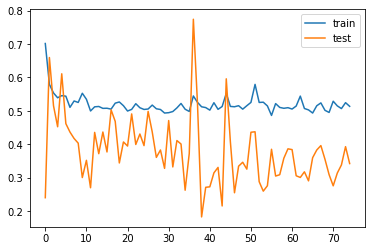

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[0.07250434160232544, 0.0]


In [10]:
best_model = create_model(neurons1=cv_best_params['neurons1'], neurons2=cv_best_params['neurons2'],
                          dropout_rate=cv_best_params['dropout_rate'], activation=cv_best_params['activation'],
                          learning_rate=cv_best_params['learning_rate'])

best_model.fit(train_X, normalized_y_train, epochs=10, batch_size=32, verbose=10)
scores = best_model.evaluate(test_X, normalized_y_test, verbose=10)
print(scores)

In [11]:
# Realizando a predição no teste
y_test_pred_lstm = best_model.predict(test_X)

y_test_pred_lstm = np.array(y_test_pred_lstm).reshape(len(y_test_pred_lstm),1)
y_test_pred_lstm = scalery.inverse_transform(y_test_pred_lstm)
y_test_pred_lstm = pd.DataFrame(y_test_pred_lstm, columns=[normalized_y_test.name], index = normalized_y_test.index )
y_test_pred_lstm = y_test_pred_lstm.squeeze()

y_test_pred_lstm



# Análise dos erros das previsões
rmse_test_lstm = math.sqrt(mean_squared_error(y_test, y_test_pred_lstm))
mae_test_lstm = mean_absolute_error(y_test, y_test_pred_lstm)
mape_test_lstm = mean_absolute_percentage_error(y_test, y_test_pred_lstm)
r2_test_lstm = r2_score(y_test, y_test_pred_lstm)


df_metricas = pd.DataFrame(data={'RSME':[rmse_test_lstm], 'MAE':[mae_test_lstm], 'MAPE':[mape_test_lstm],'R²':[r2_test_lstm]})
df_metricas

23/23 [==============================] - 0s 1ms/step


,RSME,MAE,MAPE,R²
0,9.511414,7.829994,0.146844,0.8969


In [12]:
# plotar valor real vs valor predito

# Escrever a discussão dos resultados obtidos pelos diferentes métodos de machine learning
# comentando os resultados obtidos, por exemplo: "no modelo de regressão linear a importância
# do pH do tq2 foi muito alta, não parecendo refletir a realidade". Incluir meus questionamentos e dúvidas também
# Incluir as literaturas utilizada como base (referências). Comparar com resultados de outros problemas por outras pessoas.

In [13]:
# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia

df_comparacao = pd.concat([y_test,y_test_pred_lstm],axis=1)
df_comparacao.columns = ['Valor_Real','Valor_Predito']
df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Valor_Predito'] - df_comparacao['Valor_Real'])/df_comparacao['Valor_Real']
df_comparacao.sort_index(inplace=True)
df_comparacao

,Valor_Real,Valor_Predito,Diferenca_percentual
Dia,,,
335.083601,82.855864,80.253578,-3.140738
335.125268,82.498896,80.669411,-2.217588
335.166935,82.205463,81.068703,-1.382829
335.208602,81.972441,81.451813,-0.635125
335.250268,81.797515,81.819099,0.026388
...,...,...,...
364.833625,33.145931,44.823833,35.231782
364.875292,33.142325,44.745941,35.011474
364.916959,33.144707,44.667374,34.764727


       RSME       MAE      MAPE      R²
0  9.511414  7.829994  0.146844  0.8969


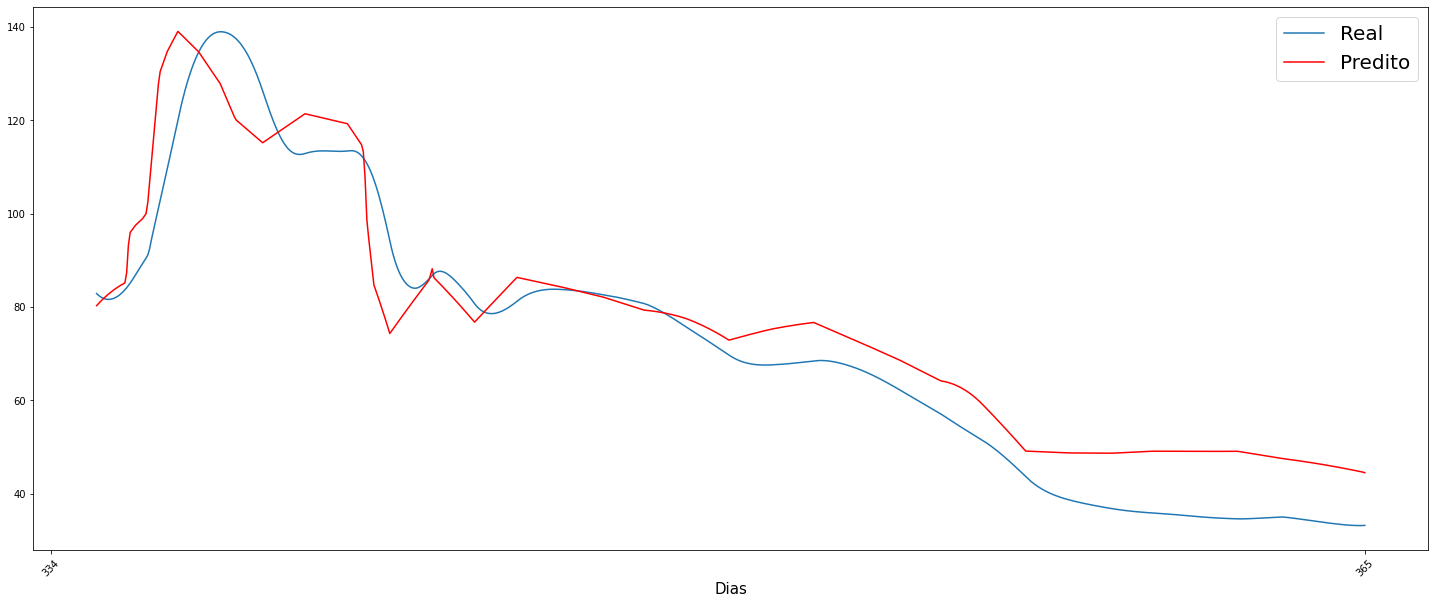

In [14]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [15]:
df_comparacao.to_csv("1_5-Previsoes_Complex_LSTM.csv",encoding='utf-8-sig',sep=';',decimal=',')

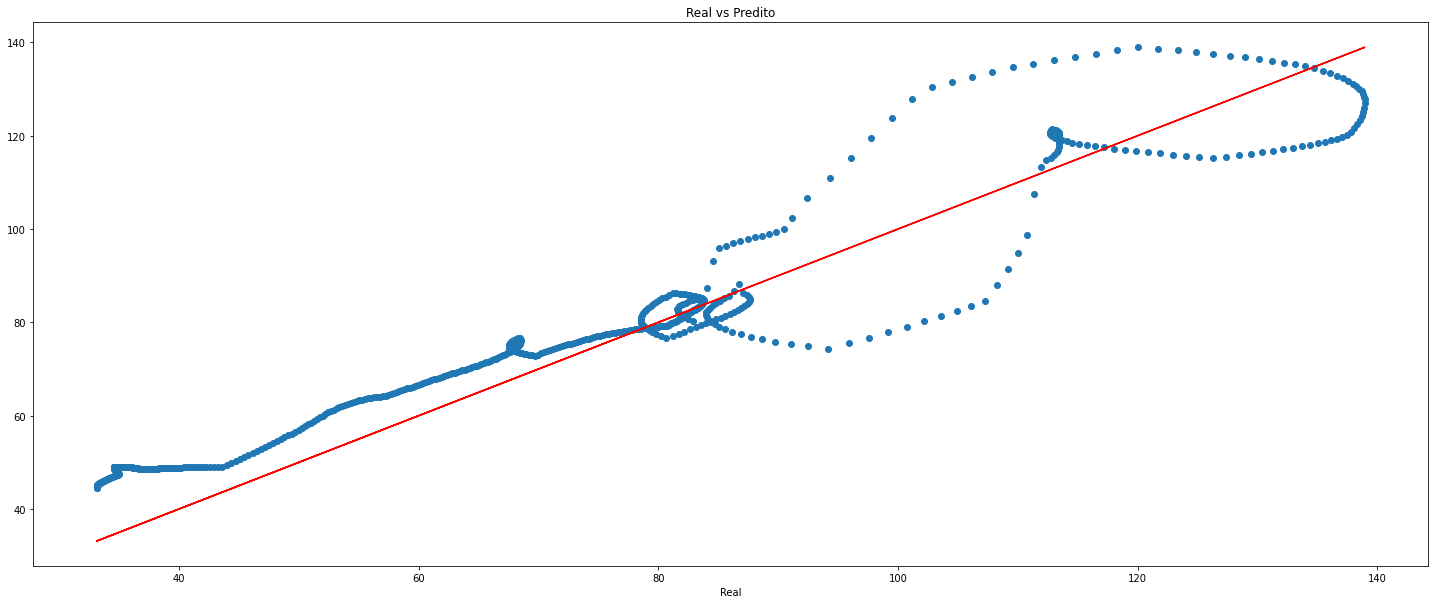

In [16]:
# Visualização gráfica das predições por valores reais
plt.figure(figsize=(25,10))
plt.title('Real vs Predito')
plt.scatter(df_comparacao['Valor_Real'], df_comparacao['Valor_Predito'])
plt.plot(df_comparacao['Valor_Real'],df_comparacao['Valor_Real'],c='r')
plt.xlabel('Previsto')
plt.xlabel('Real')
plt.show()

In [17]:
# best_model.save("LSTM_C.h5")

In [17]:
from keras.models import load_model

best_model = load_model("LSTM_C.h5")

# Previsão na base de treino

252/252 [==============================] - 0s 1ms/step
        RSME        MAE      MAPE        R²
0  21.138917  13.710089  0.130564  0.704449


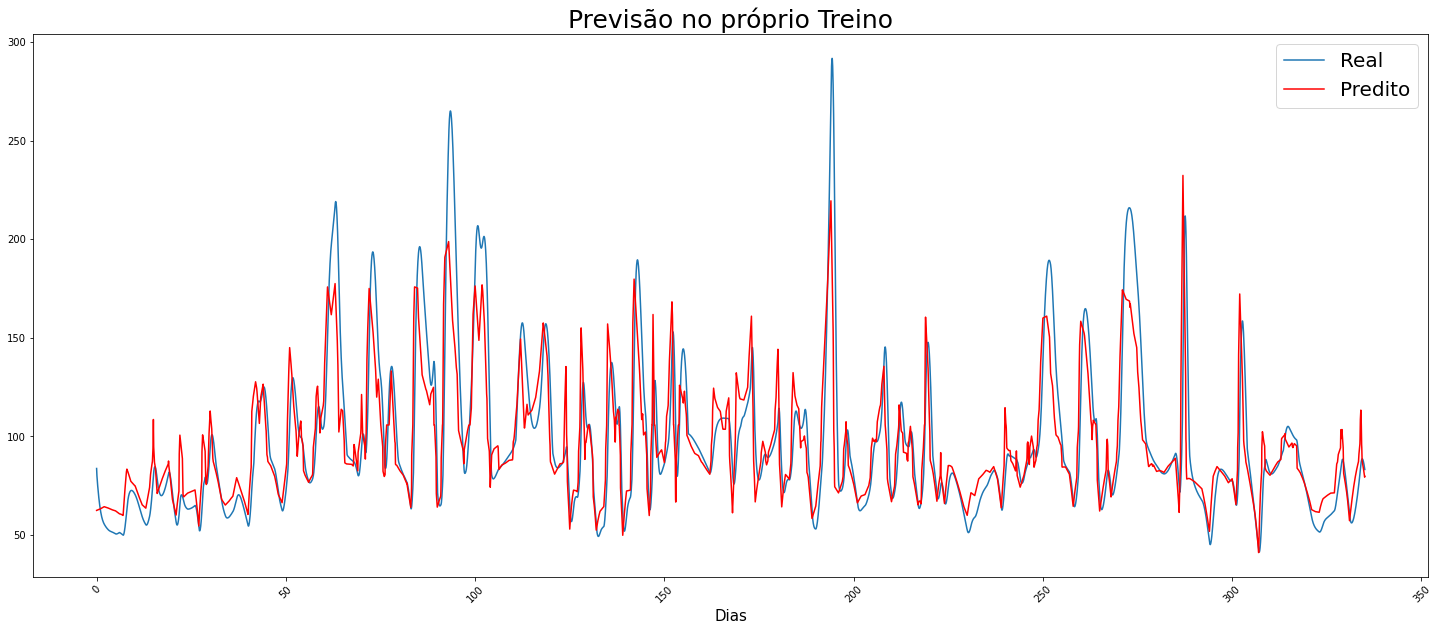

In [19]:
# Realizando a predição no traine
y_train_pred_mlp = best_model.predict(train_X)

# Desnormalização
y_train_pred_mlp = np.array(y_train_pred_mlp).reshape(len(y_train_pred_mlp),1)
y_train_pred_mlp = scalery.inverse_transform(y_train_pred_mlp)
y_train_pred_mlp = pd.DataFrame(y_train_pred_mlp, columns=[normalized_y_train.name], index = normalized_y_train.index)
y_train_pred_mlp = y_train_pred_mlp.squeeze()

y_train_pred_mlp


# Análise dos erros das previsões
rmse_train_mlp = math.sqrt(mean_squared_error(y_train, y_train_pred_mlp))
mae_train_mlp = mean_absolute_error(y_train, y_train_pred_mlp)
mape_train_mlp = mean_absolute_percentage_error(y_train, y_train_pred_mlp)
r2_train_mlp = r2_score(y_train, y_train_pred_mlp)

# Preparação do DataFrame comparativo entre a previsão e o valor real, indexado pelo dia
df_train_comparacao = pd.concat([y_training,y_train_pred_mlp],axis=1)
df_train_comparacao.columns = ['Valor_Real','Valor_Predito']
df_train_comparacao['Diferenca_percentual'] = 100*(df_train_comparacao['Valor_Predito'] - df_train_comparacao['Valor_Real'])/df_train_comparacao['Valor_Real']
df_train_comparacao.sort_index(inplace=True)
df_train_comparacao


df_train_metricas = pd.DataFrame(data={'RSME':[rmse_train_mlp], 'MAE':[mae_train_mlp], 'MAPE':[mape_train_mlp],'R²':[r2_train_mlp]})
print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
plt.title('Previsão no próprio Treino', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Valor_Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [21]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_5-Previsoes_TREINO_C_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [20]:
print(X_training.min())
print(X_training.max())

Q_entrada      3184.843533
NH_entrada        8.001116
TSS_entrada     150.229999
TN_entrada       22.245381
dtype: float64
Q_entrada      13259.806136
NH_entrada        68.927969
TSS_entrada     1033.516438
TN_entrada        88.644298
dtype: float64


In [21]:
# Calculate baseline metric
baseline_preds = best_model.predict(test_X)
baseline_metric = mean_squared_error(y_test, baseline_preds)

23/23 [==============================] - 0s 1ms/step


In [22]:
test_X.shape[2]

4

In [23]:
# Calculate feature importance via permutation importance
n_permutations = 30
feature_importance = np.zeros(test_X.shape[2])
for _ in range(n_permutations):
    for feature_idx in range(test_X.shape[2]):
        # Create a copy of the test set with shuffled values for the feature
        shuffled_X_test = test_X.copy()
        np.random.shuffle(shuffled_X_test[:, :, feature_idx])

        # Compute predictions and metric for the shuffled data
        shuffled_preds = best_model.predict(shuffled_X_test)
        shuffled_metric = mean_squared_error(y_test, shuffled_preds)

        # Calculate the feature importance for this permutation
        importance = baseline_metric - shuffled_metric
        feature_importance[feature_idx] += importance

# Average the feature importance over the permutations
feature_importance /= n_permutations

23/23 [==============================] - 0s 1ms/step


In [24]:
# Print the feature importances
for feature_idx, importance in enumerate(feature_importance):
    print(f"{df.columns[feature_idx]}: Importance = {abs(importance)}")

Q_entrada: Importance = 3.2776159134583396
NH_entrada: Importance = 7.913433613270475
TSS_entrada: Importance = 30.964358013456756
DQO_entrada: Importance = 18.02385471757786


In [25]:
importance_df = pd.DataFrame(feature_importance,index=X.columns)
importance_df = importance_df.abs()
importance_df = importance_df.sort_values(by=0)
importance_df = importance_df/importance_df.sum()
importance_df

,0
Q_entrada,0.054464
NH_entrada,0.131498
TN_entrada,0.299503
TSS_entrada,0.514535


In [26]:
importance_df.to_csv('3_5-Permutation_Importance_C_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

In [48]:
def calculate_pdp(feature_idx):
    # Select the feature for which you want to calculate the partial dependence
    selected_feature = train_X[:, :, feature_idx]

    # Create a grid of values for the selected feature
    grid_values = np.linspace(selected_feature.min(), selected_feature.max(), num=100)

    # Create a copy of the prepared dataset
    modified_data = np.copy(train_X)

    pdp_values = []
    
    # Replace feature values and generate predictions for each grid value
    for value in grid_values:
        modified_data[:, :, feature_idx] = value
        modified_predictions = best_model.predict(modified_data)

        # Calculate the average predictions
        average_predictions = np.mean(modified_predictions)

        pdp_values.append(average_predictions)

    return pdp_values

In [49]:
train_X.shape

(8042, 1, 4)

In [50]:
all_pdp_values = []
num_features = train_X.shape[2]  # Number of features in the data
pdp_intervals = []

# Calculate PDP values for all features
for feature_idx in range(num_features):
    pdp_values = calculate_pdp(feature_idx)
    all_pdp_values.append(pdp_values)

252/252 [==============================] - 0s 705us/step


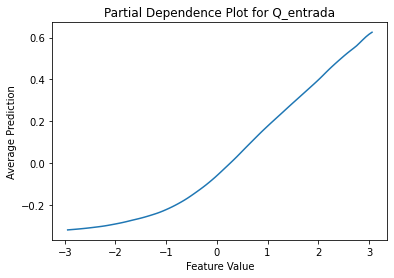

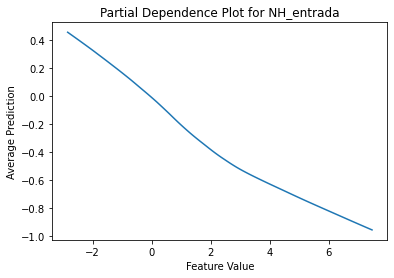

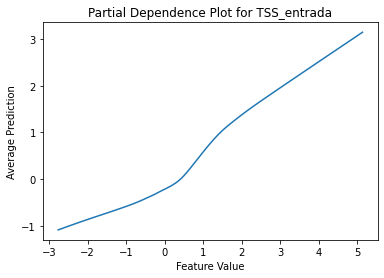

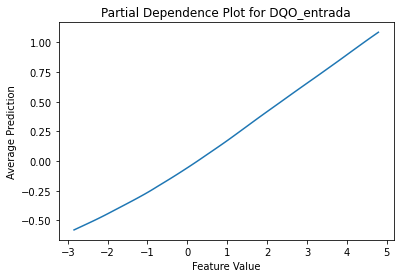

In [51]:
# Plot the PDPs for all features
for feature_idx, pdp_values in enumerate(all_pdp_values):
    grid_values = np.linspace(train_X[:, :, feature_idx].min(), train_X[:, :, feature_idx].max(), num=100)
    pdp_intervals.append(grid_values)
    
    plt.plot(grid_values, pdp_values)
    plt.xlabel('Feature Value')
    plt.ylabel('Average Prediction')
    plt.title('Partial Dependence Plot for {}'.format(df.columns[feature_idx]))
    plt.show()

In [53]:
# Values from each variable which have been used to calculate the PDPs
df_pdp_intervals = pd.DataFrame(pdp_intervals).T
df_pdp_intervals.columns = X.columns
df_pdp_intervals = df_pdp_intervals.add_suffix('_values')


# PDP values for each variable
df_pdp_values = pd.DataFrame(all_pdp_values).T
df_pdp_values.columns = X.columns
df_pdp_values = df_pdp_values.add_suffix('_importance')


# Interleave the columns from df_pdp_intervals and df_pdp_values
df_pdp = pd.concat([df_pdp_intervals, df_pdp_values], axis=1)
combined_columns = np.ravel(list(zip(df_pdp.columns[:df_pdp_intervals.shape[1]], df_pdp.columns[df_pdp_intervals.shape[1]:])))

# Rearrange the columns
df_pdp = df_pdp[combined_columns]

df_pdp.to_csv("4_5-PDPs_C_LSTM.csv",sep=';',decimal=',',encoding='utf-8-sig')

df_pdp

,Q_entrada_values,Q_entrada_importance,NH_entrada_values,NH_entrada_importance,TSS_entrada_values,TSS_entrada_importance,TN_entrada_values,TN_entrada_importance
0,-2.942186,-0.319189,-2.846533,0.455940,-2.767711,-1.086872,-2.842474,-0.579659
1,-2.881549,-0.317961,-2.742293,0.440304,-2.687921,-1.062617,-2.765335,-0.567599
2,-2.820911,-0.316751,-2.638053,0.424698,-2.608131,-1.038588,-2.688197,-0.555551
3,-2.760274,-0.315495,-2.533813,0.409092,-2.528341,-1.014785,-2.611058,-0.543508
4,-2.699636,-0.314165,-2.429573,0.393324,-2.448551,-0.991205,-2.533919,-0.531379
...,...,...,...,...,...,...,...,...
95,2.818374,0.574936,7.056268,-0.916251,4.812330,2.969658,4.485702,1.013037
96,2.879012,0.589366,7.160508,-0.925789,4.892120,3.013944,4.562841,1.031475
97,2.939649,0.603229,7.264748,-0.935316,4.971910,3.058231,4.639980,1.049709
98,3.000287,0.615362,7.368988,-0.944786,5.051700,3.102518,4.717119,1.067772
